In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import LucaM185

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


# Longer sequences (20 chars)


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]
vocab_size = len(texttoint)

sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]
val_labels = sequences[:, -1][:2000]


In [12]:
inputs[0], labels[0]

(tensor([13, 35, 13, 42, 64, 56, 54, 19, 46, 60, 15, 35, 36, 52, 59,  0, 60, 52,
         31, 60]),
 tensor(55))

# Scaling the inputs

We got a loss of 2.5 with the MLP on the last character, and looking at the example output... It couldnt really write complete words. We hope to do better by giving the model more context, other than preparing our dataset a little differently, we need to expand the input size of the first weight tensor (w1)

Step ___0 - Loss: 4.603
Step _200 - Loss: 3.020
Step _400 - Loss: 2.612
Step _600 - Loss: 2.379
Step _800 - Loss: 2.358
Step 1000 - Loss: 2.344
Step 1200 - Loss: 2.180
Step 1400 - Loss: 2.098
Step 1600 - Loss: 2.076
Step 1800 - Loss: 2.072


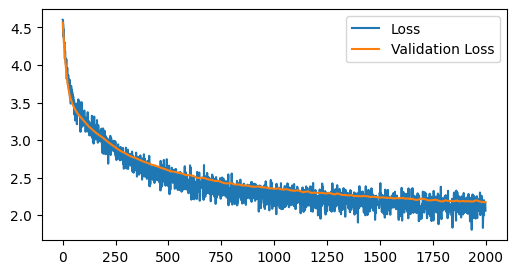

In [4]:
hidden_size = 128

w1 = torch.randn(vocab_size*sequence_length, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  # increased input size
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

steps = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float() # X.shape (batch_size, sequence_length, vocab_size)
    X = X.view(batch_size, sequence_length*vocab_size)        # X.shape (batch_size, sequence_length*vocab_size) 
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float().view(len(val_inputs), -1)
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

This is taking a while, let's explore why

In [5]:
for param, name in zip([w1, b1, w2, b2], ["w1", "b1", "w2", "b2"]):
    # print variable name, shape and number of parameters
    print(name, param.shape, param.numel())   

w1 torch.Size([1300, 128]) 166400
b1 torch.Size([128]) 128
w2 torch.Size([128, 65]) 8320
b2 torch.Size([65]) 65


The first layer has too many parameters because it scales with **sequence_length × vocab_size × hidden_size**. Reducing **sequence_length** or **hidden_size** harms performance, but **vocab_size** can be improved. Using one-hot encoding is inefficient because it uses \( \text{vocab\_size} \) dimensions to represent small integers (e.g., 65 dimensions for a single character). One-hot guarantees orthogonality, but full orthogonality isn't always necessary.

### Solution: Embeddings
We replace one-hot encoding with **embeddings**, where each token (or character) is represented as a learned vector. This approach:

- Is more parameter-efficient than one-hot encoding.
- Operates in \( O(1) \), since embeddings involve simple tensor lookups.
- Maps input tokens to a smaller, meaningful vector space.

**Why embeddings work:**
For words, embeddings capture semantic relationships. For example, "king" and "queen" may have similar embeddings, differing mainly in dimensions encoding gender. This efficient encoding allows embeddings to represent input data compactly while preserving essential distinctions.

**Single characters:**
Even for characters, embeddings work. While orthogonality is relaxed (not strict), learned embeddings distribute information effectively across dimensions, making them far more efficient than one-hot encodings.


# Embeddings

Step ___0 - Loss: 4.242
Step _200 - Loss: 2.771


Step _400 - Loss: 2.427
Step _600 - Loss: 2.399
Step _800 - Loss: 2.315
Step 1000 - Loss: 2.293
Step 1200 - Loss: 2.352
Step 1400 - Loss: 2.354
Step 1600 - Loss: 2.091
Step 1800 - Loss: 2.156


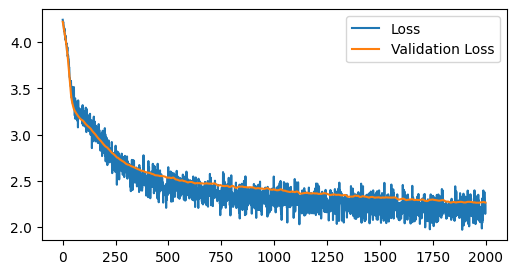

In [6]:
emb_size = 16  # Arbitrairly chosen value smaller than vocab_size
hidden_size = 128

embeddings = torch.randn(vocab_size, emb_size) / 10  # Assigning a random vector to each character in the vocabulary (this will be trained)
w1 = torch.randn(sequence_length*emb_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [embeddings, w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

steps = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)  # dont forget to add embeddings to the optimizer
lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    batch_inputs = inputs[indexes] # usual extraction of inputs
    emb = embeddings[batch_inputs] # embedding lookup
    emb = emb.view(batch_size, sequence_length*emb_size) # usual flatten
    h1 = F.gelu(emb @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        emb = embeddings[val_inputs].reshape(len(val_inputs), -1)
        h1 = F.gelu(emb @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Beware that a very small number for the embedding size will hurt performance, but 16 doesnt seem too bad

# Moving to pytorch nn.Module for cleaner code and better initialization
As you can see the model runs well, but now the complexity of the code is getting problematic, luckily pytorch has most of this already implemented. 
Just like we did before with the loss and the optimizer, here we can substitute the layers with pre made ones. 

In [7]:
class MLP(nn.Module):
    # __init__ is called when we do model = MLP()
    def __init__(self, emb_size, hidden_size): 
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.w1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.w2 = nn.Linear(hidden_size, vocab_size)
    
    # forward  is called when we do model(inputs)
    def forward(self, inputs):  
        emb = self.embeddings(inputs).view(inputs.shape[0], -1) 
        h1 = F.gelu(self.w1(emb))
        return self.w2(h1)
    
model = MLP(emb_size=16, hidden_size=128)

Step ___0 - Loss: 4.196


Step _200 - Loss: 2.596
Step _400 - Loss: 2.493
Step _600 - Loss: 2.386
Step _800 - Loss: 2.262
Step 1000 - Loss: 2.164
Step 1200 - Loss: 2.146
Step 1400 - Loss: 1.911
Step 1600 - Loss: 2.080
Step 1800 - Loss: 2.042


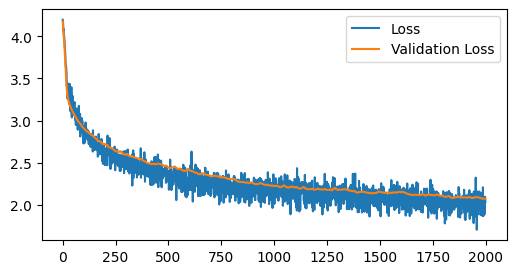

In [8]:
steps = 2000
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes]) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs)
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# GPUs for extremely fast parallel execution

As you can see the torch version works just as well, if not better and it's all around more refined

Using nn.Module class from pytorch also allows us to more easily execute the code on the GPU, which is way faster


In [9]:
device = torch.device("cuda")  # Set the device to GPU (cuda)  
model = MLP(emb_size=16, hidden_size=128).to(device)  # Send the model to GPU

Step ___0 - Loss: 4.194
Step 1000 - Loss: 2.150
Step 2000 - Loss: 1.973
Step 3000 - Loss: 1.920
Step 4000 - Loss: 1.959
Step 5000 - Loss: 1.863
Step 6000 - Loss: 1.707
Step 7000 - Loss: 1.766
Step 8000 - Loss: 1.851
Step 9000 - Loss: 1.741


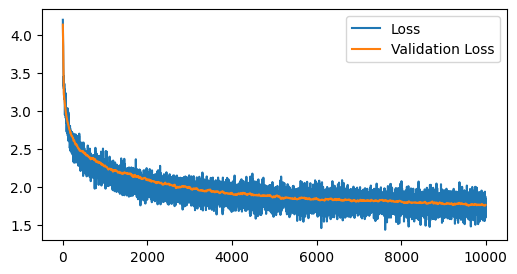

In [10]:
steps = 10000
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device))  # Send the inputs to GPU
    loss = F.cross_entropy(pred, labels[indexes].to(device))  # Send the labels to GPU

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Note: GPUs are often bandwith bound, not compute bound, so higher batch sizes play well with text, for example it may be that from 1 to 512 the training time stays basically the same, because the gpu is able to compute all of these in parallel and under a certain batch size you will not be taking advantage of this. <br>


In [11]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(1000):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


             
KING RICHARD II:
O, sholl mad Balled an who gether in word gaid; I gad astleed:
And partime, for you and usand,
And roundere so me hall mind witch.

DUCHESS OF YORK:
Say, I shall stean to take
Het fackre not any a lord;
and to whole sant to colse that Be merefing? for of bothingo:
Now, sir, tears it sibe freain.
Bay sweid you hear toids of may nellse heaven deken sed thourd nondiegh ummous
Jybult, be him heir His all from At, no halten bir?

CORIOLANUS:
In ary
he hell unto mear, or for untigness: ame come sponfolls it, theil fur holl-sbe; shath hearth sudse, thore plast in thich semething; your prights!

CORIOLANUS:

Jhour eill emys delding
IZAnd, what badet thy repono!
Where mist chnuceury to the tring, I am son.

KING LEWERD IV:
For hatter:
But hank, sie in these of this ploud;
Of my ind the to preweess to grecerts are
condereding when buble my poop to shill pars, eouresed foo.

Jrickrenty pringbed, I
prown! more, detcouldstice folet.

QUENERSSO:
Not, brether you't hen 

The model is spitting out nosense but it clearly resembles the text it's trained on... Let's see how we can improve on this in part 5